# Calculating time scales for *cis/trans* isomerization


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import os

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

## Load in the omega angle trajectories by result

In [6]:
# Parameters
residues_to_plot = [0, 1, 2]  # Residues to plot
num_residues = len(residues_to_plot)

save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (742, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")
all_cistrans[0]

First array shape after conversion: (350495, 3)


array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 0]])

## compile transition probabilities as a function of lag time (in steps)

In [7]:
def compute_transition_matrix(subset, num_states, lagtime, pseudocount=0.25):
    """Compute transition matrix for a given subset of trajectories."""
    
    C = np.zeros((num_states, num_states))  # Initialize count matrix

    for traj in subset:
        for t in range(len(traj) - lagtime):
            from_state = traj[t]
            to_state = traj[t + lagtime]

            # Skip NaN transitions
            if np.isnan(from_state) or np.isnan(to_state):
                continue

            # Convert states to integers for indexing
            from_state = int(from_state)
            to_state = int(to_state)

            # Count transitions
            C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities
    row_sums = C.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    T = C / row_sums        
    
    return T

In [8]:
def compute_stationary_distribution(T, lagtime):
    """Compute the stationary distribution of a transition matrix T.
    
    INPUT:
    T - Transition matrix where T_ij is the probability of transitioning i -> j.
    
    RETURN:
    pi - The stationary distribution (1D NumPy array).
    t2 - The implied timescale (in units of steps).
    """
    try:
        # Compute the implied timescale
        evals = np.linalg.eigvals(T.transpose() )  # will be something like [0.99754545 1.        ]
        evals_sorted = np.sort(evals)      # ascending order
        mu2 = evals_sorted[-2]            # second-largest eigenvalue
        #print('mu2', mu2, 'evals', evals, 'evals_sorted', evals_sorted, 'T', T)
        
        t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
        #print('evals_sorted', evals_sorted, 'mu2', mu2, 't2', t2)

        # Compute the stationary state distribution 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)  # (T' - I)
        A = np.vstack([A, np.ones(n_states)])  # Append normalization row
        b = np.zeros(n_states + 1)
        b[-1] = 1  # Ensure probability sums to 1
        
        # Solve for stationary distribution using least squares
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
        # Ensure non-negative values and normalize
        pi = np.maximum(pi, 0)  # Prevent small negative values due to numerical error
        pi /= np.sum(pi)  # Normalize to sum to 1

    except Exception as e:
        print(f"Error computing stationary distribution: {e}")
        t2 = np.nan
        pi = None

    return pi, t2

In [9]:
def get_transition_matrices(n_trajs, num_states, lagtime, cluster_size=10, pseudocount=0.25, n_jobs=-1):
    """
    Compute transition matrices for subsets of trajectories in parallel.
    """

    num_trajs = n_trajs.shape[0]  # Number of trajectories
    
    # Shuffle indices
    indices = np.arange(num_trajs)
    np.random.shuffle(indices)

    # Split into clusters
    clusters = [indices[i:i + cluster_size] for i in range(0, num_trajs, cluster_size)]

    # Merge last small cluster with the second-last if needed
    if len(clusters) > 1 and len(clusters[-1]) < cluster_size:
        clusters[-2] = np.concatenate([clusters[-2], clusters[-1]])  
        clusters.pop()

    # Parallel computation of transition matrices
    def process_cluster(cluster):
        subset = n_trajs[cluster]
        # Call your existing compute_transition_matrix
        T = compute_transition_matrix(subset, num_states, lagtime, pseudocount)
        return T

    # Use joblib's Parallel for parallelism. 
    # `delayed(process_cluster)(c)` calls `process_cluster(c)` lazily.
    # `n_jobs=-1` uses all available CPUs unless specified otherwise.
    transition_matrices = Parallel(n_jobs=n_jobs)(
        delayed(process_cluster)(cluster) 
        for cluster in tqdm(clusters, desc="Computing transition matrices", unit="cluster")
    )

    return transition_matrices


In [10]:
def process_trajectory(n_trajs, lagtime, num_states, cluster_size):

    # Calculate the transition matrix 
    transition_matrices = get_transition_matrices(n_trajs, num_states, lagtime, cluster_size, pseudocount=0.25, n_jobs=-1)
    transition_matrices = np.array(transition_matrices)
    #print('transition_matrices.shape', transition_matrices.shape)

    # Calculate the stationary population 
    pi_all = []
    t2_all = []

    
    for T in transition_matrices:
        pi, t2 = compute_stationary_distribution(T, lagtime)
        pi_all.append(pi)
        t2_all.append(t2)

    pi_all = np.array(pi_all)
    t2_all = np.array(t2_all)


    t2_mean = np.exp(np.nanmean([np.log(t2) for t2 in t2_all]))
    t2_std = np.exp(np.sqrt(np.nanvar([np.log(t2) for t2 in t2_all])))
    pi_means = np.nanmean(pi_all, axis=0)  # Mean across trajectories
    pi_std = np.std(pi_all, axis=0)  # Standard deviation   
    
    return pi_means, pi_std, t2_mean, t2_std

#print(pi_all)

## Let's make an implied timescale plot for each omega angle

In [11]:
## Create a nah filling array where to make sure all the traj are the same length

ntraj = len(all_omega)

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

traj


maxlength 492298


array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

(492298, 3)


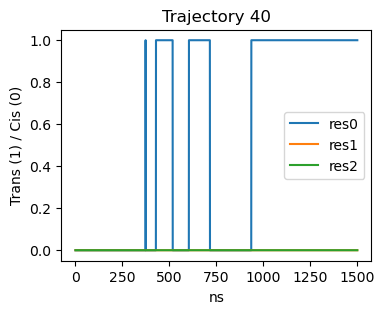

(492298, 3)


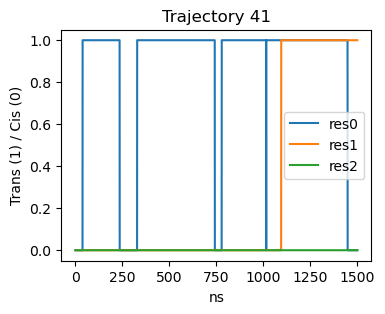

(492298, 3)


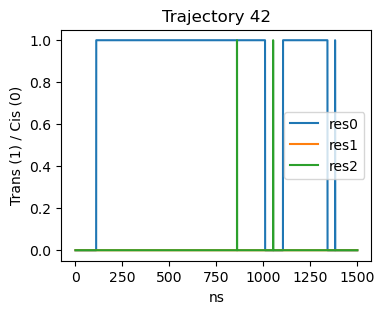

(492298, 3)


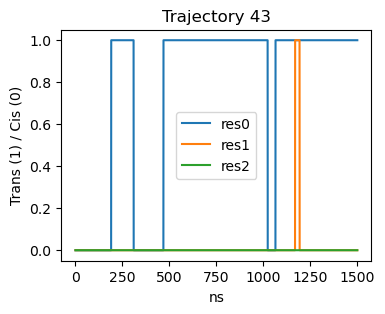

(492298, 3)


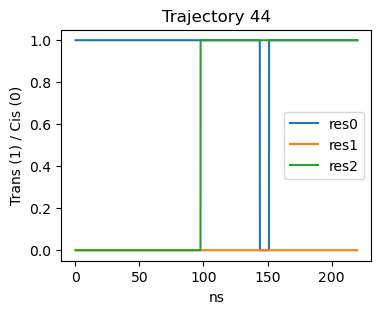

In [16]:
step_to_plot = np.arange(1, 150000)  # Corrected step range
dt_in_ns = 0.01 # 10 ps to 1 ns

for i in range(40, 45):
    plt.figure(figsize=(4, 3))  # new figure for each trajectory
    print(traj[i].shape)
    plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 0], label='res0')  # X component
    plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 1], label='res1')  # Y component
    plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 2], label='res2')  # Z component
    
    
    plt.xlabel("ns")
    plt.ylabel("Trans (1) / Cis (0)")
    plt.legend(loc='best')  # Automatically places the legend in the best position
    plt.title(f"Trajectory {i}")
    plt.show()


Processing residue 0 with lagtimes = [5, 50, 100, 5100, 10100, 15100, 20100, 25100, 30100, 35100, 40100, 45100, 50100, 55100, 60100, 65100, 70100, 75100, 80100, 85100, 90100, 95100]


Computing transition matrices: 100%|██████████| 10/10 [00:00<00:00, 6627.12cluster/s]
/var/folders/d8/y2dvs1ln1gjcwccrkvtffr240000gn/T/ipykernel_91728/606344109.py:18: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
Processing Lag Times: 100%|██████████| 22/22 [30:10<00:00, 82.29s/lag]


Processing residue 1 with lagtimes = [5, 50, 100, 5100, 10100, 15100, 20100, 25100, 30100, 35100, 40100, 45100, 50100, 55100, 60100, 65100, 70100, 75100, 80100, 85100, 90100, 95100]


Processing Lag Times: 100%|██████████| 22/22 [31:02<00:00, 84.67s/lag]


Processing residue 2 with lagtimes = [5, 50, 100, 5100, 10100, 15100, 20100, 25100, 30100, 35100, 40100, 45100, 50100, 55100, 60100, 65100, 70100, 75100, 80100, 85100, 90100, 95100]


Processing Lag Times: 100%|██████████| 22/22 [30:41<00:00, 83.70s/lag]


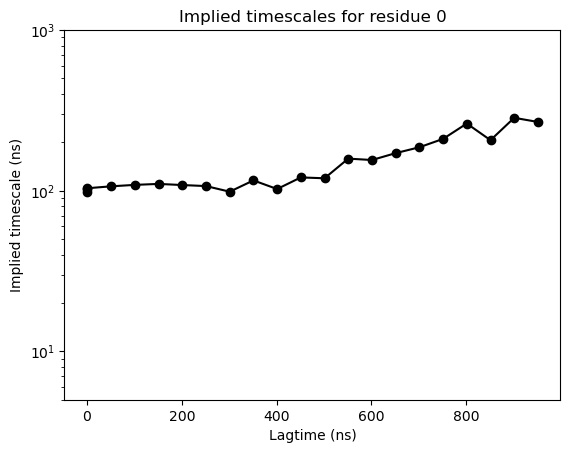

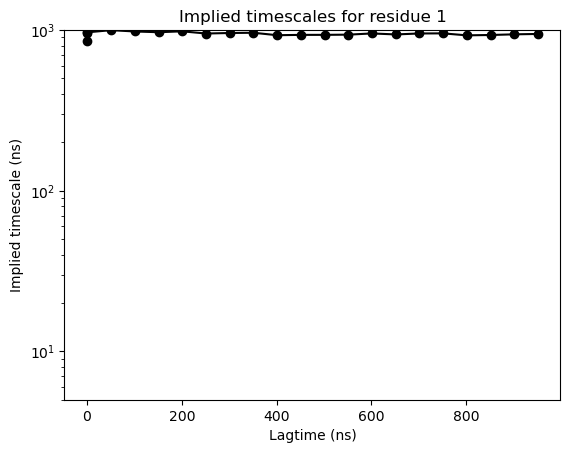

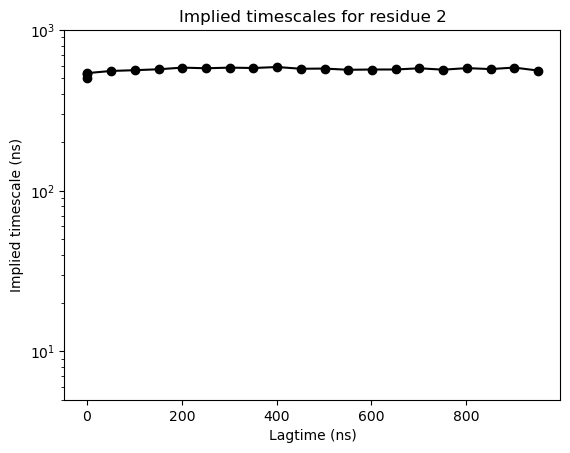

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

dt_in_ns = 0.01
residues = [0, 1, 2]
#residues = [0]

n_result = len(all_omega)  # Ensure all_omega is defined
n_trajs = traj  # Ensure traj is defined

num_states = 2
#lagtimes = [5]
lagtimes = [5, 50] + list(range(100, 100000, 5000))
cluster_size = 80

# Store results with proper shape: (n_residues, n_lagtimes)
pi_all_means = []
pi_all_stds = []
t2_all_means = []
t2_all_stds = []

for residue in residues:
    print(f'Processing residue {residue} with lagtimes = {lagtimes}')
    
    pi_means_res = []
    pi_stds_res = []
    t2_means_res = []
    t2_stds_res = []
    
    for lagtime in tqdm(lagtimes, desc="Processing Lag Times", unit="lag"):
        pi_means, pi_std, t2_mean, t2_std = process_trajectory(n_trajs[:, :, residue], lagtime, num_states, cluster_size)
        
        pi_means_res.append(pi_means)
        pi_stds_res.append(pi_std)
        t2_means_res.append(t2_mean)
        t2_stds_res.append(t2_std)

    # Append per-residue results
    pi_all_means.append(pi_means_res)
    pi_all_stds.append(pi_stds_res)
    t2_all_means.append(t2_means_res)
    t2_all_stds.append(t2_stds_res)

# Convert to NumPy arrays for easier indexing
pi_all_means = np.array(pi_all_means)  # Shape: (n_residues, n_lagtimes)
pi_all_stds = np.array(pi_all_stds)
t2_all_means = np.array(t2_all_means)
t2_all_stds = np.array(t2_all_stds)

lagtimes_ns = np.array(lagtimes) * dt_in_ns

# Plotting
for i, residue in enumerate(residues):
    plt.figure()
    plt.plot(lagtimes_ns, t2_all_means[i] * dt_in_ns, 'ko-')
    plt.fill_between(lagtimes_ns, 
                     (t2_all_means[i] + t2_all_stds[i]) * dt_in_ns, 
                     (t2_all_means[i] - t2_all_stds[i]) * dt_in_ns, 
                     alpha=0.2)
    plt.xlabel('Lagtime (ns)')
    plt.ylabel('Implied timescale (ns)')
    plt.ylim(5, 1000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue}')
    plt.savefig(f"autocoorel_data/implied_timescale_res{residue}.png")
    plt.show()


In [27]:
# Create an instance of Data with your arrays
data_instance = Data([pi_all_means, pi_all_stds, 
                      t2_all_means, t2_all_stds, lagtimes_ns])

# Save to a file
data_instance.save("autocoorel_data/stationary_distributions_1us_5000stride_res.pkl")
print(f" data save at autocoorel_data/stationary_distributions_1us_5000stride_res.pkl")

 data save at autocoorel_data/stationary_distributions_1us_5000stride_res.pkl


In [28]:
pi_all_means.shape

(3, 22, 2)

## Reload and plot the data

### One Whole Transition Matrix

In [9]:
omega_loaded = Data.load("autocoorel_data/stationary_distributions_1us_5000stride_res.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_stds = omega_loaded[1]
t2_all_means = omega_loaded[2]
t2_all_stds = omega_loaded[3]
lagtimes_ns = omega_loaded[4]

pi_all_means.shape
t2_all_stds


array([[1.05209192, 1.04882406, 1.05532061, 1.05223557, 1.07671906,
        1.10091859, 1.0901022 , 1.12720323, 1.32540026, 1.18016973,
        1.30792665, 1.18985822, 1.23039039, 1.16925209, 1.17716088,
        1.18945613, 1.27088715, 1.30883507, 1.27328494, 1.35081441,
        1.30095283, 1.16874537],
       [1.14248927, 1.10340667, 1.13423544, 1.13894462, 1.10083712,
        1.11417898, 1.07102086, 1.0807061 , 1.15075461, 1.19002566,
        1.10616772, 1.21112195, 1.17488111, 1.29612766, 1.09856672,
        1.19742334, 1.13041018, 1.26710728, 1.20512622, 1.22266198,
        1.17009297, 1.25387913],
       [1.08358617, 1.04475864, 1.0919415 , 1.07936489, 1.10211664,
        1.10867247, 1.12658322, 1.13916083, 1.13014966, 1.13832483,
        1.10753139, 1.09434256, 1.18560271, 1.18492091, 1.26661584,
        1.20178085, 1.15838141, 1.23428259, 1.16906195, 1.25233535,
        1.26850528, 1.37189666]])

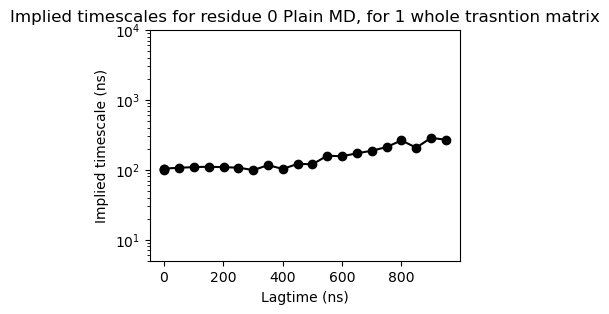

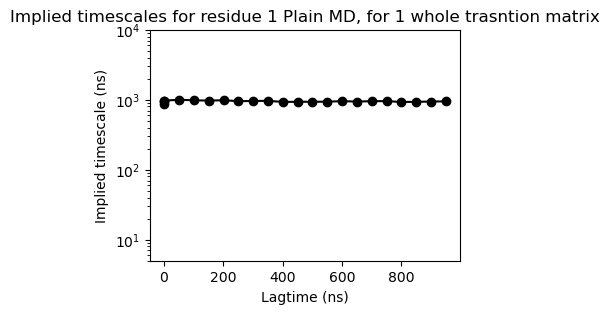

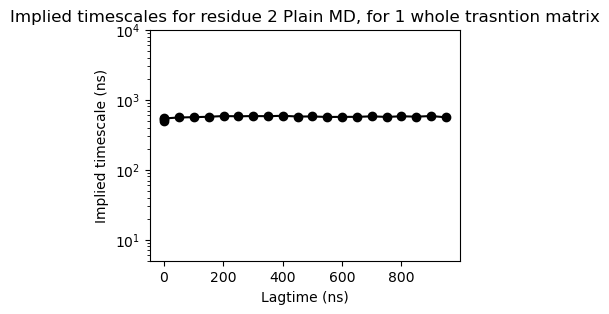

In [12]:
# Plotting
residues = [0, 1, 2]
dt_in_ns = 0.01 # 10 ps per step
for i, residue in enumerate(residues):
    plt.figure(figsize=(4,3))
    plt.plot(lagtimes_ns, t2_all_means[i] * dt_in_ns, 'ko-')
    plt.fill_between(lagtimes_ns, 
                     (t2_all_means[i] + t2_all_stds[i]) * dt_in_ns, 
                     (t2_all_means[i] - t2_all_stds[i]) * dt_in_ns, 
                     alpha=1)
    plt.xlabel('Lagtime (ns)')
    plt.ylabel('Implied timescale (ns)')
    plt.ylim(5, 10000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue} Plain MD, for 1 whole trasntion matrix')
    #plt.show()
    plt.savefig(f"autocoorel_data/implied_timescale_res{residue}.png")

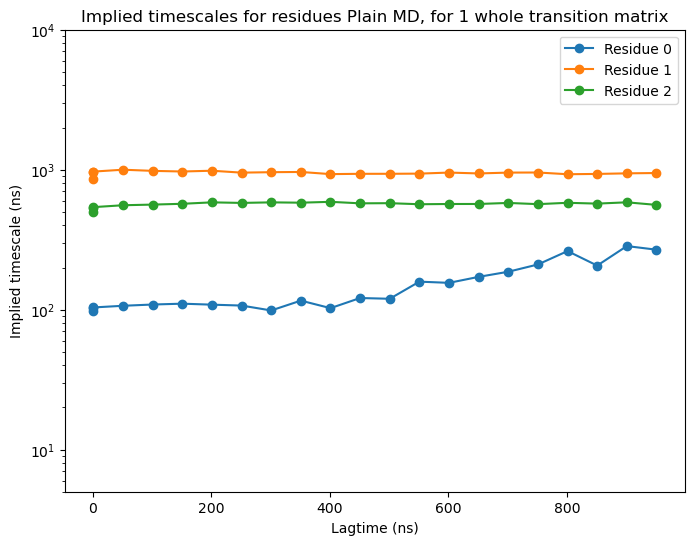

In [13]:
import matplotlib.pyplot as plt

residues = [0, 1, 2]
dt_in_ns = 0.01  # 10 ps per step

plt.figure(figsize=(8, 6))  # Create a single figure

for i, residue in enumerate(residues):
    plt.plot(lagtimes_ns, t2_all_means[i] * dt_in_ns, 'o-', label=f'Residue {residue}')
    plt.fill_between(lagtimes_ns, 
                     (t2_all_means[i] + t2_all_stds[i]) * dt_in_ns, 
                     (t2_all_means[i] - t2_all_stds[i]) * dt_in_ns, 
                     alpha=0.2)

plt.xlabel('Lagtime (ns)')
plt.ylabel('Implied timescale (ns)')
plt.ylim(5, 10000)
plt.yscale('log')
plt.title('Implied timescales for residues Plain MD, for 1 whole transition matrix')
plt.legend()  # Add a legend to differentiate residues

#plt.show()
plt.savefig("autocoorel_data/implied_timescale_all_residues.png")


201.0:0.276
201.0:0.724


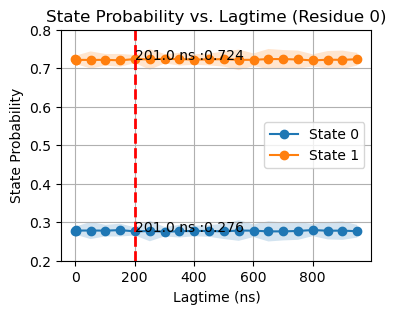

201.0:0.561
201.0:0.439


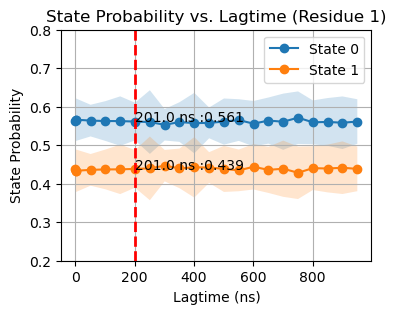

201.0:0.458
201.0:0.542


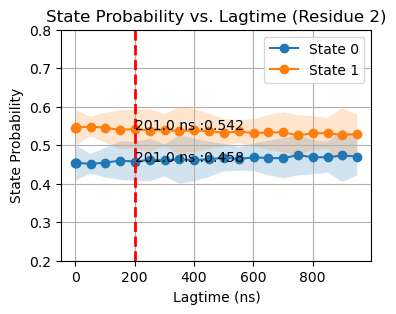

In [15]:
import matplotlib.pyplot as plt

residues = [0, 1, 2]
dt_in_ns = 0.01  # 10 ps per step
state_to_plot = [0, 1]

for res in residues:
    plt.figure(figsize=(4, 3))  # Create a new figure for each residue
    pi_means = pi_all_means[res]
    pi_stds = pi_all_stds[res] 

    for i, state in enumerate(state_to_plot):
        plt.plot(lagtimes_ns, pi_means[:, i], '-o', label=f'State {state}')
        
        # Add shaded region for standard deviation
        plt.fill_between(lagtimes_ns, 
                         pi_means[:, i] + pi_stds[:, i],  # Upper bound
                         pi_means[:, i] - pi_stds[:, i],  # Lower bound
                         alpha=0.2)
        
        # Annotate the first point with its value
        first_x = lagtimes_ns[6]
        first_y = pi_means[6, i]
        plt.text(first_x, first_y,  f"{first_x} ns :{first_y:.3f}", fontsize=10)
        print(f"{first_x}:{first_y:.3f}")

    #plt.axhline(y=0.475, color='r', linestyle='--', linewidth=2, label='0.475')
    plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)
    plt.xlabel("Lagtime (ns)")
    plt.ylabel("State Probability")
    plt.title(f"State Probability vs. Lagtime (Residue {res})")
    plt.ylim(0.2, 0.8)
    plt.legend()
    plt.grid(True)
    
    # Fix: Use `res` instead of `residue`
    plt.savefig(f"autocoorel_data/stationary_population_res{res}.png", dpi=300)
    plt.show()


In [17]:
## Save the data into a csv

point_to_plot = 20
lagtime_plot = 6  # index of lagtime to extract at 101 ns
selected_ns = lagtimes_ns[lagtime_plot]  # for saving


# Collect into a list of dicts for easy DataFrame creation
data_rows = []

for res_index in range(3):  # 3 trajectories

    res = pi_all_means[res_index]  # shape (604, 2)
    std = pi_all_stds[res_index]

    mean_val = res[lagtime_plot, 1]  # Trans
    std_val = std[lagtime_plot, 1]

    data_rows.append({
        'res': res_index,
        'lagtime_index': lagtime_plot,
        'lagtime_ns': selected_ns,
        'mean': mean_val,
        'std': std_val
    })

# Create a DataFrame
df = pd.DataFrame(data_rows)

# Save to CSV (or change to .tsv)
df.to_csv("autocoorel_data/trans_population_at_lagtime.csv", index=False)

print("Saved data to autocoorel_data/trans_population_at_lagtime.csv")
df


Saved data to autocoorel_data/trans_population_at_lagtime.csv


,res,lagtime_index,lagtime_ns,mean,std
0,0,6,201.0,0.723847,0.010731
1,1,6,201.0,0.438522,0.048915
2,2,6,201.0,0.542281,0.050703
